In [1]:
%load_ext autoreload
%autoreload 2

In [275]:
import __init__ as chess
from __init__ import Board
from svg import board

In [4]:
import os

pieces_dir = 'piece'
piece_sets = os.listdir(pieces_dir)

- alpha - good
- anarcandy - good
- cburnett - good
- chessnut - good
- companion - good
- fresca - good
- governor - good
- monarcy - good
- mono - good
- mpchess - good
- pirouetti - good
- pixel - good
- reillycraig - good
- riohacha - good
- shapes - good
- staunty - good
- tatiana - good
- caliente - good
- california - good
- cardinal - good
- celtic - good
- dubronvy - good
- fantasy - good
- gioco - good
- leipzig - good 
- letter - good
- libra - good
- maestro - good
- merida - good
- monarchy - good
- cooke - good
- kosal - good
- spatial - good
- chess7 - good
- horsey - good
- icpieces - good
- kiwen-suwi - good

Below we make some tweaks to the actual SVG files to be able to add their raw content in the `<defs>` tag of the outer board's `<svg>`. To do this:
- `id` attributes must to be globally unique
- classes defined in `<style>` tags must (should) be globally unique
- the `viewBox` attribute needs to be specified
- `height` and `width` attributes are not required (they will always be sized by a `<use>` tag)

To solve the first two, the code below prepends each ID and class name with the piece "code", ex. `wP-` or `bN-`, within each file.

Then to solve the last two, it removes the `height` and `width` attributes and adds a `viewBox` attribute if it doesn't exist by setting it like `viewBox="0 0 [oldHeight] [oldWidth]"`.

In [78]:
def make_ids_unique(svg_content: str, piece_code: str) -> str:
    """
    Read all SVG files in the given piece set dir. These should have names like
    'wP.svg', 'wN.svg', etc. (or 'P.svg', 'N.svg', etc. for the `mono` piece set).
    Prepend all appropriate `id` and `href` attributes in the SVG with the piece code
    and a hyphen (ex. 'wP-') to ensure global uniqueness when rendering an SVG with
    the full board. Then write the output to `output_piece_set_dir`.
    """
    # Replace all `id` and `href` attributes with the piece code prepended
    # `id`s will look like 'id="someId"` and the corresponding `href`s will look like 'href="#someId"'
    import re

    # Replace strings matching ex. `id="someId"` with `id="[pieceCode]-someId"
    svg_content = re.sub(r'id="([^"]+)"', f'id="{piece_code}-\\1"', svg_content)

    # Replace strings matching ex. `href="#someId"` with `href="#[pieceCode]-someId"
    svg_content = re.sub(r'href="#([^"]+)"', f'href="#{piece_code}-\\1"', svg_content)

    # Replace strings matching ex. `"url(#someId)"` with `"url(#[pieceCode]-someId)"`
    svg_content = re.sub(r'url\(#([^"]+)\)', f'url(#{piece_code}-\\1)', svg_content)

    # Get a list of all strings matching `id="..."` and verify that they are all unique
    ids = re.findall(r'id="([^"]+)"', svg_content)
    assert len(ids) == len(set(ids)), f'Non-unique IDs found for piece set {piece_code}'

    return svg_content

def make_classes_unique(svg_content: str, piece_code: str) -> str:
    """
    """
    import re

    # Replace all class names in style blocks (`<style>...</style>`) with `[pieceCode]-[className]`.
    # Also make a list of the class names that are being replaced so we can change where they are used.
    style_blocks = re.findall(r'<style>(.*?)</style>', svg_content, re.DOTALL)

    if len(style_blocks) == 0:
        return svg_content

    assert len(style_blocks) == 1, f'Expected exactly one <style> block in the SVG file:\n{svg_content}'
    style_block = style_blocks[0]

    # Get a list of all class names in the style block
    class_names = re.findall(r'\.([a-zA-Z_][a-zA-Z0-9_-]*)', style_block)

    # Replace all class names in the style block with `[pieceCode]-[className]`
    for class_name in class_names:
        old_class_name_def = f'.{class_name}'
        new_class_name_def = f'.{piece_code}-{class_name}'
        style_block = style_block.replace(old_class_name_def, new_class_name_def)
        
    # Replace the original style block with the modified one
    svg_content = svg_content.replace(style_blocks[0], style_block)

    # Replace the old class names with the new ones (`oldClassName` -> `[pieceCode]-oldClassName`).
    # Do a negative lookbehind to ensure we don't match any strings where the previous character is
    # a dot (ex. `.oldClassName`) or a hypen (where it may have already been replaced by ex. `wP-oldClassName`).
    for class_name in class_names:
        old_class_name = f'(?<![-.]){class_name}'
        new_class_name = f'{piece_code}-{class_name}'
        svg_content = re.sub(old_class_name, new_class_name, svg_content)
    
    return svg_content

def width_height_to_viewbox(svg_content: str) -> str:
    """
    Remove width and height attributes from the SVG, and if a viewBox attribute doesn't already exist,
    create it by setting it to the value "0 0 [oldWidth] [oldHeight]".
    """

    # Get the outer SVG element
    import xml.etree.ElementTree as ET
    root = ET.fromstring(svg_content)

    # Get the width and height attributes
    width = root.get('width')
    height = root.get('height')

    # Get the viewBox attribute
    viewbox = root.get('viewBox')

    # If the viewBox attribute doesn't exist, create it
    if viewbox is None:
        assert width is not None and height is not None, 'Both width/height and viewBox attributes are missing from the SVG'
        viewbox = f'0 0 {width} {height}'
        root.set('viewBox', viewbox)
    
    # Remove the width and height attributes
    if width is not None:
        assert height is not None, 'Width attribute exists but height attribute is missing'
        root.attrib.pop('width')
        root.attrib.pop('height')

    # Serialize the XML back to a string
    return ET.tostring(root, encoding='unicode')


for piece_set in piece_sets:
    svg_files = [f for f in os.listdir(os.path.join('piece', piece_set)) if f.endswith('.svg')]
    
    for svg_file in svg_files:
        piece_code = os.path.splitext(svg_file)[0]
        with open(os.path.join('piece', piece_set, svg_file), 'r') as f:
            svg_content = f.read()
        
        svg_content = make_ids_unique(svg_content, piece_code)
        svg_content = make_classes_unique(svg_content, piece_code)
        svg_content = width_height_to_viewbox(svg_content)

        with open(os.path.join('new_piece', piece_set, svg_file), 'w') as f:
            f.write(svg_content)

In [94]:
i = 0
b = Board()
b.push_san('e4')
b.push_san('c6')
b.push_san('d4')
b.push_san('d5')
b.push_san('e5')
b.push_san('Bf5')
b.push_san('Nf3')
b.push_san('g6')
b.push_san('Bd3')
b.push_san('Bg7')
b.push_san('O-O');

In [1]:
piece_set = 'cardinal'

print(f'Piece set: {piece_set}')
import cairosvg
from IPython.display import Image
Image(cairosvg.svg2png(board(b, piece_set=piece_set, size=400, lastmove=b.peek(), coordinates=False)))

Piece set: cardinal


ModuleNotFoundError: No module named 'cairosvg'

In [231]:
from collections import deque


def split_not_in_quotes(
    s: str, delim: str = ' ', quotes: list[tuple[str, str]] | None = None
) -> list[str]:
    """
    Split a string on a delimeter if the delimeter is not inside a pair of quotes.
    """
    if quotes is None:
        quotes = [('"', '"'), ("'", "'")]

    # Validate that the 'quotes' are all 1 character long
    assert all(
        len(q[0]) == 1 and len(q[1]) == 1 for q in quotes
    ), "All quotes must be exactly 1 character long"

    # Loop through the string and keep track of whether we are inside a quoted string using a stack
    stack = deque()
    splits = []
    current_split = []

    for char in s:
        if not stack and char == delim:
            splits.append("".join(current_split))
            current_split = []
        else:
            current_split.append(char)

        if stack and char == stack[-1]:
            stack.pop()
        elif not stack:
            for open_quote, close_quote in quotes:
                if char == open_quote:
                    stack.append(close_quote)
                    break

    # Add the last split
    if current_split:
        splits.append("".join(current_split))

    return splits

In [299]:
os.listdir('new_piece')

['alpha',
 'anarcandy',
 'caliente',
 'california',
 'cardinal',
 'cburnett',
 'celtic',
 'chess7',
 'chessnut',
 'companion',
 'cooke',
 'dubrovny',
 'fantasy',
 'fresca',
 'gioco',
 'governor',
 'horsey',
 'icpieces',
 'kiwen-suwi',
 'kosal',
 'leipzig',
 'letter',
 'libra',
 'maestro',
 'merida',
 'monarchy',
 'mono',
 'mpchess',
 'pirouetti',
 'pixel',
 'reillycraig',
 'riohacha',
 'shapes',
 'spatial',
 'staunty',
 'tatiana']

In [232]:
import re


def deduplicate_svg_attrs(svg_string: str) -> str:
    """Deduplicate the attributes in the outer `<svg>` tag in the given SVG string."""

    # We just want to match the very first <svg> opening tag, ex:
    # <svg xmlns="http://www.w3.org/2000/svg" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 0 45 45">
    # Then we do a simple string manipulation to remove duplicate attributes
    PAT = re.compile(r'<svg ?([^>]*)>')
    svg_attrs = re.match(PAT, svg_string).group(1)

    # We shouldn't assume the attributes' values are always the same even if the attribute names are the same.
    # However, if there are two attributes with the same name, the one that will be used is the last one, so
    # as we iterate through the attrs, we can always overwrite the previous value.
    attrs = {}
    for attr in split_not_in_quotes(svg_attrs):
        key, value = attr.split('=', 1)
        attrs[key] = value

    # Reconstruct the attributes string
    new_attrs = ' '.join([f'{key}={value}' for key, value in attrs.items()])
    return re.sub(PAT, f"<svg {new_attrs}>", svg_string, count=1)

Piece set: cardinal
test: piece_svg:


'<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 0 45 45" width="400" height="400"><svg fill-rule="evenodd" clip-rule="evenodd" image-rendering="optimizeQuality" shape-rendering="geometricPrecision" text-rendering="geometricPrecision" viewBox="0 0 50 50"><defs><filter id="wB-c" color-interpolation-filters="sRGB"><feGaussianBlur result="blur" stdDeviation="0.01 0.01" /></filter><filter id="wB-b" color-interpolation-filters="sRGB"><feFlood flood-color="#000" flood-opacity=".5" result="flood" /><feComposite in="flood" in2="SourceGraphic" operator="in" result="composite1" /><feGaussianBlur in="composite1" result="blur" stdDeviation=".3" /><feOffset dx="1" dy="1" result="offset" /><feComposite in="SourceGraphic" in2="offset" result="composite2" /></filter><linearGradient id="wB-a" x1="13197" x2="13341" y1="-9591" y2="-9591" gradientTransform="translate(-3485.7 2562.6) scale(.26458)" gradientUnits="userSpaceOnUse"><stop offset="0" stop-color="#ff

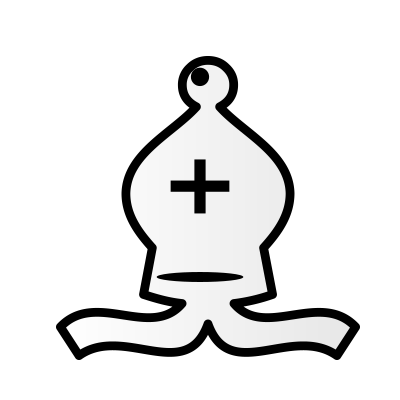

In [291]:
from svg import piece, board
import cairosvg

PIECE_SET = 'cardinal'
print('Piece set:', PIECE_SET)


# piece_svg = piece(chess.Piece(chess.PAWN, chess.BLACK))
piece_svg = deduplicate_svg_attrs(piece(chess.Piece(chess.BISHOP, chess.WHITE), size=400, piece_set=PIECE_SET))
# board_svg = board(b, piece_set=PIECE_SET)
# print('test: board_svg:\n', board_svg)
piece_svg = """<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" viewBox="0 0 45 45" width="400" height="400"><svg fill-rule="evenodd" clip-rule="evenodd" image-rendering="optimizeQuality" shape-rendering="geometricPrecision" text-rendering="geometricPrecision" viewBox="0 0 50 50"><defs><filter id="wB-c" color-interpolation-filters="sRGB"><feGaussianBlur result="blur" stdDeviation="0.01 0.01" /></filter><filter id="wB-b" color-interpolation-filters="sRGB"><feFlood flood-color="#000" flood-opacity=".5" result="flood" /><feComposite in="flood" in2="SourceGraphic" operator="in" result="composite1" /><feGaussianBlur in="composite1" result="blur" stdDeviation=".3" /><feOffset dx="1" dy="1" result="offset" /><feComposite in="SourceGraphic" in2="offset" result="composite2" /></filter><linearGradient id="wB-a" x1="13197" x2="13341" y1="-9591" y2="-9591" gradientTransform="translate(-3485.7 2562.6) scale(.26458)" gradientUnits="userSpaceOnUse"><stop offset="0" stop-color="#fff" /><stop offset="1" stop-color="#e6e6e6" /></linearGradient></defs><path fill="url(#wB-a)" stroke="#000" stroke-linejoin="round" stroke-width="1.1" d="M25 6.55c-.88 0-1.65.29-2.26.9a2.86 2.86 0 0 0-.95 2.16c0 1.23.58 2.13 1.76 2.74-2.97 3.29-8.7 5.82-8.81 10.83 0 2.67 1.46 4.76 3.3 6.8l-1.1 5.83c1.69.54 3.08.94 4.82 1.13-3.88 4.58-10.79-1.74-15.21 2.93l2.33 3.58c5.6-3.96 13.38 3.67 16.12-3.96 2.75 7.63 10.53 0 16.12 3.96l2.33-3.58c-4.42-4.67-11.33 1.65-15.2-2.93a23.1 23.1 0 0 0 4.82-1.13l-1.12-5.83c1.85-2.04 3.3-4.13 3.31-6.8-.1-5-5.84-7.54-8.8-10.83 1.17-.61 1.75-1.51 1.75-2.74 0-.84-.3-1.55-.95-2.16-.6-.61-1.38-.9-2.26-.9z" filter="url(#wB-b)" /><ellipse cx="2720.3" cy="-271.4" class="st15" filter="url(#wB-c)" rx="16.3" ry="2.5" transform="matrix(.33232 0 0 .24998 -879.01 102.47)" /><ellipse cx="25" cy="9.61" class="st15" rx="1.14" ry="1.15" /><path fill="none" stroke="#000" stroke-width="1.4" d="M21.33 23.27h7.34M25 19.93v6.75" /></svg></svg>"""
print('test: piece_svg:')
display(piece_svg)

from IPython.display import Image

# Show the piece PNG
piece_png = cairosvg.svg2png(bytestring=piece_svg)
display(Image(piece_png))

# # Show the board PNG
# board_png = cairosvg.svg2png(bytestring=board_svg)
# display(Image(board_png))

Write a directory of converted PNGs.

Note: all the piece sets looked good after this except for `cardinal` which had some weird spacing/viewBox issues. Looks like these occur whether we render with `svg.piece()` or `svg.board()`. For that piece set, I just converted all the SVGs to PNGs manually at https://svgtrace.com/svg-to-png.

In [283]:
import os
from __init__ import PIECE_TYPES, COLORS, Piece

PIECE_PNG_DIR = 'piece_png'

# Get a 400x400 PNG of each piece in each piece set and save it to the `piece_png` directory.
# Filenames should be like `wP.png`, `wN.png`, etc., unless the piece set is `mono`, in
# which case they should be like `P.png`, `N.png`, etc. (since white and black pieces are all
# gray and use the same SVGs).

# Create the `piece_png` directory if it doesn't exist
if not os.path.exists(PIECE_PNG_DIR):
    os.makedirs(PIECE_PNG_DIR)

PIECES = [Piece(piece_type, color) for color in COLORS for piece_type in PIECE_TYPES]
def get_piece_code(p: Piece, is_mono: bool = False) -> str:
    if is_mono:
        return p.symbol().upper()
    return f'{chess.COLOR_NAMES[p.color][0].lower()}{p.symbol().upper()}'

for piece_set in piece_sets:
    PIECE_SET_PNG_DIR = os.path.join(PIECE_PNG_DIR, piece_set)
    if not os.path.exists(PIECE_SET_PNG_DIR):
        os.makedirs(PIECE_SET_PNG_DIR)
    
    for p in PIECES:
        piece_svg = deduplicate_svg_attrs(piece(p, size=400, piece_set=piece_set))
        piece_png = cairosvg.svg2png(bytestring=piece_svg)
        piece_code = get_piece_code(p, piece_set == 'mono')
        piece_png_path = os.path.join(PIECE_SET_PNG_DIR, f'{piece_code}.png')
        
        with open(piece_png_path, 'wb') as f:
            f.write(piece_png)